In [1]:
basedir = '/home/abhinavgupta0110/generalized_nCM'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'generalized_nCMs'))

%load_ext autoreload

### Load modules

In [3]:
%autoreload 2

from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralODE_train_HOTs as ncm
import src.bio_eqn_case.bio_eqn as bio
from src.bio_eqn_case.bio_Eqn_Helper_Classes import * 

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import scipy.interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from shutil import move
import pickle

print(tf.__version__) 

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.5.0


## Define some useful classes

In [4]:
class bio_eq_ncm_args(ncm.ncm_arguments, bio.bio_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, 
                 decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 tau_max = 1.1, tau = 0.2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 365, nt = 365, nz = 50, z_max = -100, a = 0.07, g_max = 0.81e-5 * (60*60*24), k_P = 0.06, 
                 k_D = 0.01, k_W = 0.08, K_N = 0.5, K_P = 0.25, m_p = 9.26e-7 * (60*60*24), m_z = 6.94e-7 * (60*60*24), 
                 T_opt = 20, mu_max = 3.25e-5 * (60*60*24), alpha = 1.62e-6 * (60*60*24), beta = 3.24e-8 * (60*60*24), 
                 epsilon = 1.736e-7 * (60*60*24), lamb = 0.3, gamma = 0.4, C_P = 6.625, C_Z = 5.625, C_D = 7.5, 
                 gamma_c = 0.01, T_bio_min = 10, T_bio_max = 10, Temp = None, Salt = None, I_0 = 158.075, K_z0 = 8.64, 
                 K_zb = 0.0864, gamma_K = 0.1, bio_model_low_complex = 'NPZD-OA', 
                 bio_model_high_complex = 'NPZD-OA', isplot = True,
                 ode_alg_name = 'dopri5', nsteps = -1, is_tstart_zero = True, 
                 lambda_l1_mark = 0., lambda_l2_mark = 0., 
                 lambda_l1_non_mark = 0., lambda_l2_non_mark = 0., prune_thres = 0., mse_weight = 0., max_deriv = 2,
                 acc = 2, extra_terms_high_complex = 1, extra_terms_low_complex = 0, 
                 train_ens_size = 1, ens_to_plot = -1, skip_bnd = 0): # add more arguments as needed

        ncm.ncm_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, 
                           tau_max = tau_max, tau = tau, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)

        self.args_train_lf = [bio.bio_eqn_args(T = T, nt = nt, nz = nz, z_max = z_max, a = a, g_max = g_max, k_P = k_P, 
                                  k_D = k_D, k_W = k_W, K_N = K_N, K_P = K_P, m_p = m_p, m_z = m_z, T_opt = T_opt, 
                                  mu_max = mu_max, alpha = alpha, beta = beta, epsilon = epsilon, lamb = lamb, 
                                  gamma = gamma, C_P = C_P, C_Z = C_Z, C_D = C_D, gamma_c = gamma_c, T_bio_min = T_bio_min, 
                                  T_bio_max = T_bio_max, bio_model = bio_model_low_complex, Temp = Temp, Salt = Salt, I_0 = I_0, 
                                  K_z0 = K_z0, K_zb = K_zb, gamma_K = gamma_K, extra_terms = extra_terms_low_complex,
                                  acc = acc, max_deriv = max_deriv, skip_bnd = skip_bnd)]
        
        self.args_train_hf = [bio.bio_eqn_args(T = T, nt = nt, nz = nz, z_max = z_max, a = a, g_max = g_max, k_P = k_P, 
                                  k_D = k_D, k_W = k_W, K_N = K_N, K_P = K_P, m_p = m_p, m_z = m_z, T_opt = T_opt, 
                                  mu_max = mu_max, alpha = alpha, beta = beta, epsilon = epsilon, lamb = lamb, 
                                  gamma = gamma, C_P = C_P, C_Z = C_Z, C_D = C_D, gamma_c = gamma_c, T_bio_min = T_bio_min, 
                                  T_bio_max = T_bio_max, bio_model = bio_model_high_complex, Temp = Temp, Salt = Salt, I_0 = I_0, 
                                  K_z0 = K_z0, K_zb = K_zb, gamma_K = gamma_K, extra_terms = extra_terms_high_complex,
                                  acc = acc, max_deriv = max_deriv, skip_bnd = skip_bnd)]
        
        self.train_ens_size = train_ens_size
        
        self.args_eval_hf = self.args_train_hf[ens_to_plot]
        self.args_eval_lf = self.args_train_lf[ens_to_plot]
        
        self.bio_model_low_complex = bio_model_low_complex
        self.bio_model_high_complex = bio_model_high_complex
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps
        
        self.lambda_l1_mark = lambda_l1_mark
        self.lambda_l2_mark = lambda_l2_mark
        self.lambda_l1_non_mark = lambda_l1_non_mark
        self.lambda_l2_non_mark = lambda_l2_non_mark
        self.prune_thres = prune_thres
        self.mse_weight = mse_weight

In [5]:
class sigmoid_func:
    def __init__(self, T_top, T_bot, z_max):
        self.T_top = T_top
        self.T_bot = T_bot
        self.z_max = z_max
        
    def __call__(self, z, t):
        A = self.T_top
        K = self.T_bot
        C = 1
        Q = 0.5
        B = 0.25
        nu = 2.0
        T = lambda x: A + ((K - A) / (C + Q * np.exp(-B*x))**(1./nu))
        
        T = np.stack([ T(np.abs(z) + self.z_max/2) for i in range(t.shape[0])], axis=0)
        
        return T

### Class for user-defined arguments

In [6]:
args = bio_eq_ncm_args(batch_time = 6*1, batch_time_skip = 2, batch_size = 2, epochs = 200, learning_rate = 0.075, 
                 decay_rate = 0.97, test_freq = 1, plot_freq = 1, 
                 model_dir = 'BioOA_nODE_testcase/model_dir_test', restart = 0, val_percentage = 11.,
                 T = 30, nt = 300, nz = 20, z_max = -100, a = 0.07, g_max = 0.81e-5 * (60*60*24), k_P = 0.06, 
                 k_D = 0.01, k_W = 0.08, K_N = 0.5, K_P = 0.25, m_p = 9.26e-7 * (60*60*24), m_z = 6.94e-7 * (60*60*24) / 2, 
                 T_opt = 20, mu_max = 3.25e-5 * (60*60*24), alpha = 1.62e-6 * (60*60*24), beta = 3.24e-8 * (60*60*24), 
                 epsilon = 1.736e-7 * (60*60*24), lamb = 0.3, gamma = 0.4, C_P = 6.625, C_Z = 5.625, C_D = 7.5, 
                 gamma_c = 0.01, T_bio_min = 10, T_bio_max = 20, Temp = sigmoid_func(20, 20, -100), 
                 Salt = sigmoid_func(31.4, 32.8, -100), I_0 = 158.075, K_z0 = 8.64, 
                 K_zb = 0.0864, gamma_K = 0.1, bio_model_low_complex = 'NPZD-OA', 
                 bio_model_high_complex = 'NPZD-OA', isplot = True, ode_alg_name = 'dopri5', nsteps = 100, 
                 is_tstart_zero = False, lambda_l1_mark = 1e-5, lambda_l2_mark = 1e-5, 
                 prune_thres = 5e-3, mse_weight = 0., max_deriv = 2,
                 acc = 2, extra_terms_high_complex = 1, skip_bnd = 0)

In [7]:
testcase_dir = 'generalized_nCMs/testcases/bio_eqn'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir, save_user_inputs=False)

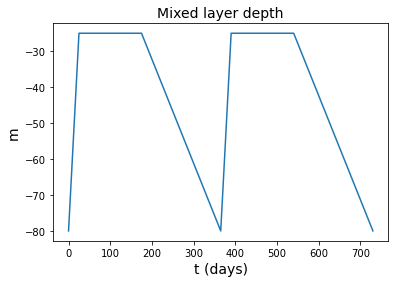

Higher complexity model done!


In [8]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup

In [19]:
class custom_plot:

    def __init__(self, z, t, args, K_obj = None):
        self.t = t
        self.args = args
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        self.K_obj = K_obj
        
    def plot(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None, str_fmt = '%.2f'):
        
        fig = plt.figure(figsize=(10, 55), facecolor='white')
        ax_N = fig.add_subplot(611)
        ax_P = fig.add_subplot(612)
        ax_Z = fig.add_subplot(613)
        ax_D = fig.add_subplot(614)
        ax_DIC = fig.add_subplot(615)
        ax_TA = fig.add_subplot(616)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        B_D = tf.transpose(tf.squeeze(pred_y[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy()
        B_DIC = tf.transpose(tf.squeeze(pred_y[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy()
        B_TA = tf.transpose(tf.squeeze(pred_y[:, :, 5*self.args.nz:6*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [[np.min(B_N.flatten()), np.max(B_N.flatten())]]
            max_cbar.append([np.min(B_P.flatten()), np.max(B_P.flatten())])
            max_cbar.append([np.min(B_Z.flatten()), np.max(B_Z.flatten())])
            max_cbar.append([np.min(B_D.flatten()), np.max(B_D.flatten())])
            max_cbar.append([np.min(B_DIC.flatten()), np.max(B_DIC.flatten())])
            max_cbar.append([np.min(B_TA.flatten()), np.max(B_TA.flatten())])
        
        self.plot_indiv(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap, t_max)
        self.plot_indiv(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap, t_max)
        self.plot_indiv(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap, t_max)
        self.plot_indiv(ax_D, title_start + ' D ' + title_end, B_D, max_cbar[3], cmap, t_max)
        self.plot_indiv(ax_DIC, title_start + ' DIC ' + title_end, B_DIC, max_cbar[4], cmap, t_max)
        self.plot_indiv(ax_TA, title_start + ' TA ' + title_end, B_TA, max_cbar[5], cmap, t_max, str_fmt = str_fmt)

        plt.show()
        
    def plot_with_mld(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None):
        
        fig = plt.figure(figsize=(10, 55), facecolor='white')
        ax_N = fig.add_subplot(611)
        ax_P = fig.add_subplot(612)
        ax_Z = fig.add_subplot(613)
        ax_D = fig.add_subplot(614)
        ax_DIC = fig.add_subplot(615)
        ax_TA = fig.add_subplot(616)
        
        B_N = tf.transpose(tf.squeeze(pred_y[:, :, 0:self.args.nz], axis=1)).numpy()
        B_P = tf.transpose(tf.squeeze(pred_y[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy()
        B_Z = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        B_D = tf.transpose(tf.squeeze(pred_y[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy()
        B_DIC = tf.transpose(tf.squeeze(pred_y[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy()
        B_TA = tf.transpose(tf.squeeze(pred_y[:, :, 5*self.args.nz:6*self.args.nz], axis=1)).numpy()
        
        if max_cbar == None:
            max_cbar = [[np.min(B_N.flatten()), np.max(B_N.flatten())]]
            max_cbar.append([np.min(B_P.flatten()), np.max(B_P.flatten())])
            max_cbar.append([np.min(B_Z.flatten()), np.max(B_Z.flatten())])
            max_cbar.append([np.min(B_D.flatten()), np.max(B_D.flatten())])
            max_cbar.append([np.min(B_DIC.flatten()), np.max(B_DIC.flatten())])
            max_cbar.append([np.min(B_TA.flatten()), np.max(B_TA.flatten())])
        
        self.plot_indiv_with_mld(ax_N, title_start + ' N ' + title_end, B_N, max_cbar[0], cmap, t_max)
        self.plot_indiv_with_mld(ax_P, title_start + ' P ' + title_end, B_P, max_cbar[1], cmap, t_max)
        self.plot_indiv_with_mld(ax_Z, title_start + ' Z ' + title_end, B_Z, max_cbar[2], cmap, t_max)
        self.plot_indiv_with_mld(ax_D, title_start + ' D ' + title_end, B_D, max_cbar[3], cmap, t_max)
        self.plot_indiv_with_mld(ax_DIC, title_start + ' DIC ' + title_end, B_DIC, max_cbar[4], cmap, t_max)
        self.plot_indiv_with_mld(ax_TA, title_start + ' TA ' + title_end, B_TA, max_cbar[5], cmap, t_max)

        plt.show()

        
    def plot_indiv(self, ax, title, B, max_cbar_lim, cmap, t_max=None, str_fmt = '%.2f'):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 40), extend='both')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10, format=str_fmt, spacing='proportional', ticks=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 5))
        cbar.ax.tick_params(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        
    def plot_indiv_with_mld(self, ax, title, B, max_cbar_lim, cmap, t_max=None, str_fmt = '%.2f'):
        ax.cla()
        ax.set_title(title, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 40), extend='both')
        
        
        ax.plot(self.t, self.K_obj.M_intrp(self.t), linewidth=3, color='r', linestyle='--')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10, format=str_fmt, spacing='proportional', ticks=np.linspace(max_cbar_lim[0], max_cbar_lim[1], 5))
        cbar.ax.tick_params(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        
    def plot_solar_intensity(self, t_max=None):
        fig = plt.figure(figsize=(4.2, 1), facecolor='white')
        ax = fig.add_subplot(111)
        
        f = ax.plot(self.t, self.args.I_0_t(self.t), linewidth=2, color='k')
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        ax.set_title('Solar Radiation', fontsize=12)
        ax.set_ylabel('$I_0$ (W $m^{-2}$)', fontsize=12)
        ax.set_xlabel('t (days)', fontsize=12)
        plt.xticks([*range(0, 400, 100)], fontsize = 11)
        plt.yticks(fontsize = 11)
        
    def plot_indiv_cover_img(self, pred_y, title_start, title_end, max_cbar = None, cmap = cm.coolwarm, t_max=None):
        
        fig = plt.figure(figsize=(6, 5), facecolor='white')
        ax = fig.add_subplot(111)
        
        B = tf.transpose(tf.squeeze(pred_y[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy()
        
        ax.set_title(title_start + ' Z ' + title_end, fontsize=22)
        ax.set_ylabel('z (m)', fontsize=22)
        ax.set_xlabel('t (days)', fontsize=22)
        plot = ax.contourf(self.T, self.Z, B, cmap=cmap,
                           antialiased=False, levels=np.linspace(0, max_cbar, 40), extend='both')
        ax.set_ylim(self.z[-1], self.z[0])
        if t_max == None:
            ax.set_xlim(self.t[0], self.t[-1])
        else:
            ax.set_xlim(self.t[0], t_max)
        
        cbar = plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10, format='%.2f', spacing='proportional', ticks=np.linspace(0, max_cbar, 5))
        cbar.ax.tick_params(labelsize=20)
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        
        plt.gcf().set_dpi(600)
        
        plt.show()

In [20]:
custom_plot_obj = custom_plot(args.args_eval_lf.z, tf.concat([t, val_t], axis=0), args.args_eval_lf, K_z_obj)

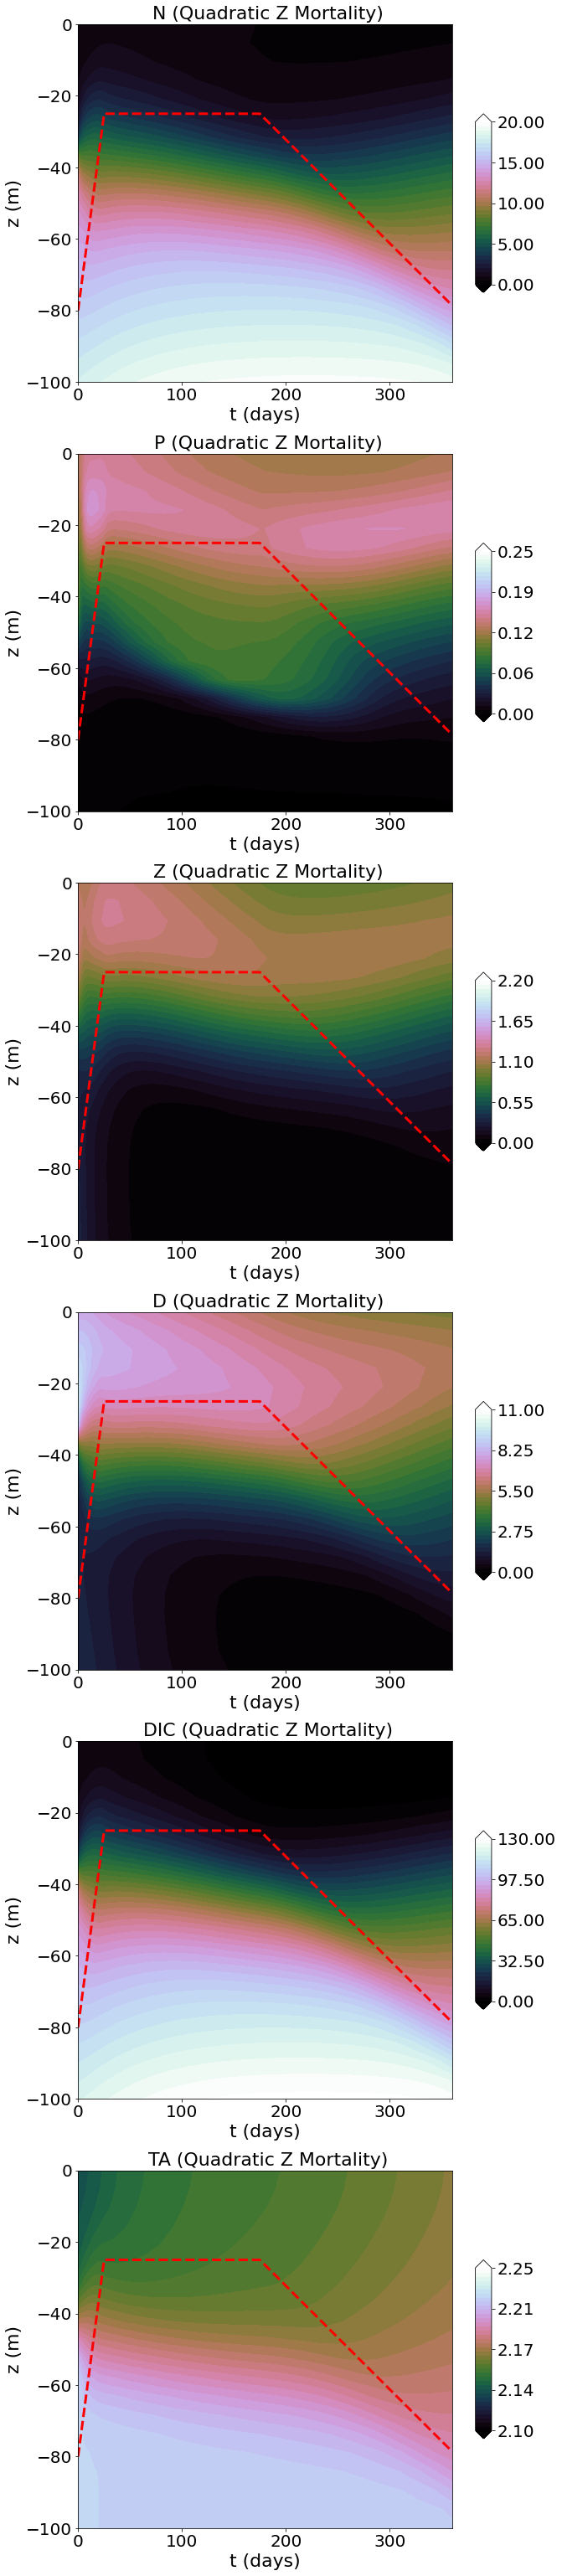

In [33]:
custom_plot_obj.plot_with_mld(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), '', '(Quadratic Z Mortality)', max_cbar = [[0, 20.], [0, .25], [0, 2.2], [0, 11.], [0, 130.], [2.1, 2.25]], cmap = cm.cubehelix)

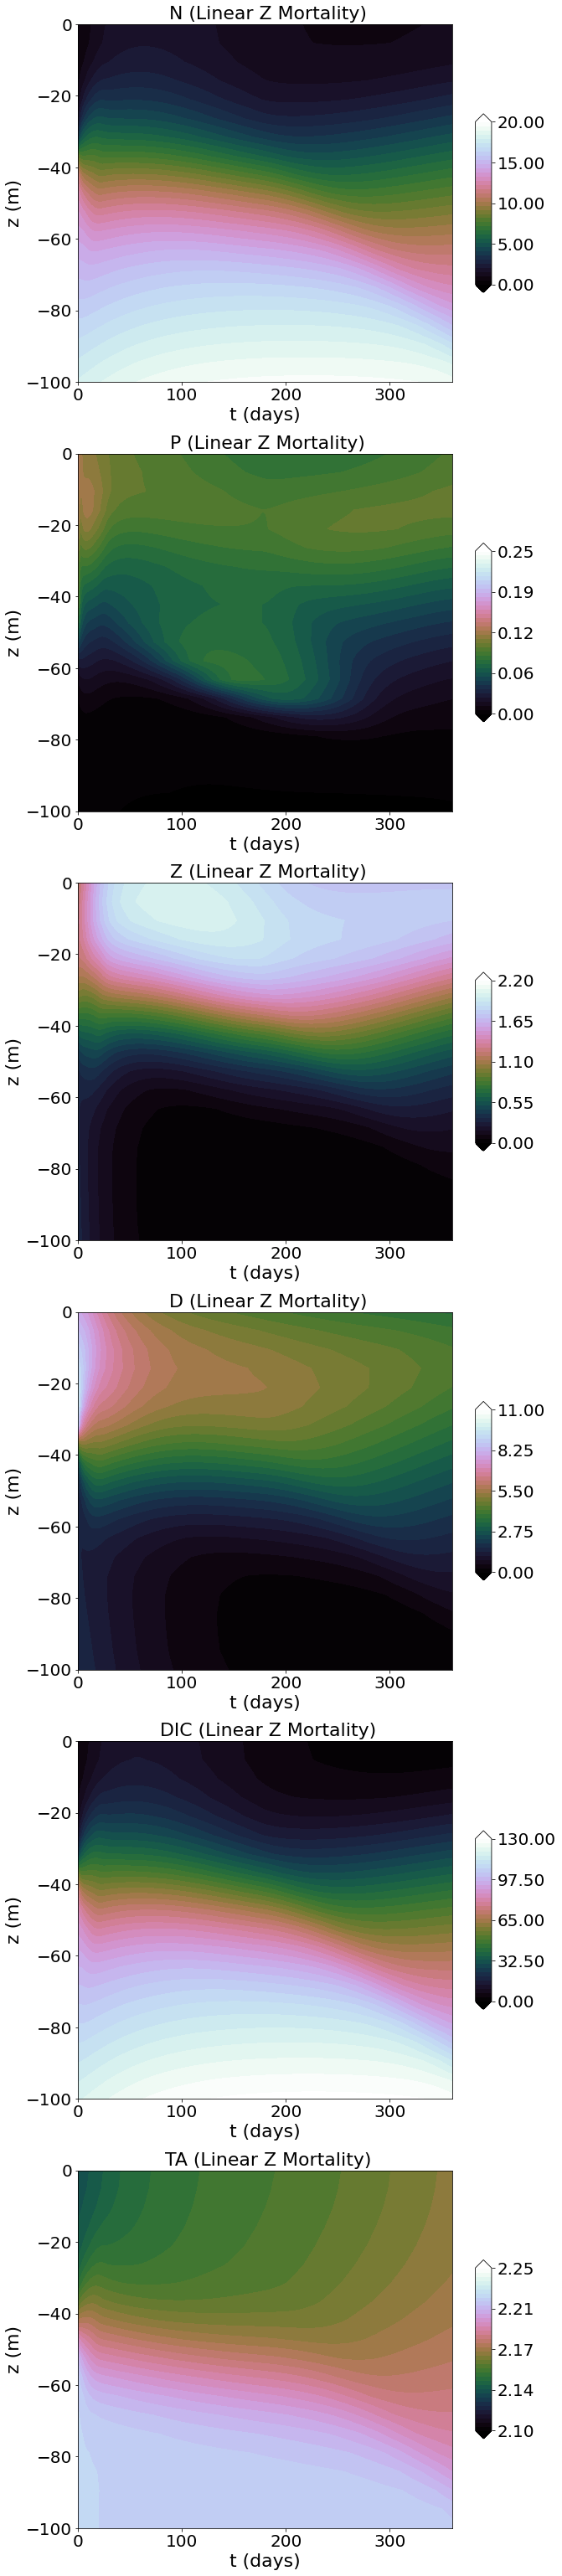

In [32]:
custom_plot_obj.plot(tf.concat([x_low_complex, val_x_low_complex], axis=0), '', '(Linear Z Mortality)', max_cbar = [[0, 20.], [0, .25], [0, 2.2], [0, 11.], [0, 130.], [2.1, 2.25]], cmap = cm.cubehelix)

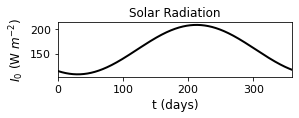

In [13]:
custom_plot_obj.plot_solar_intensity()

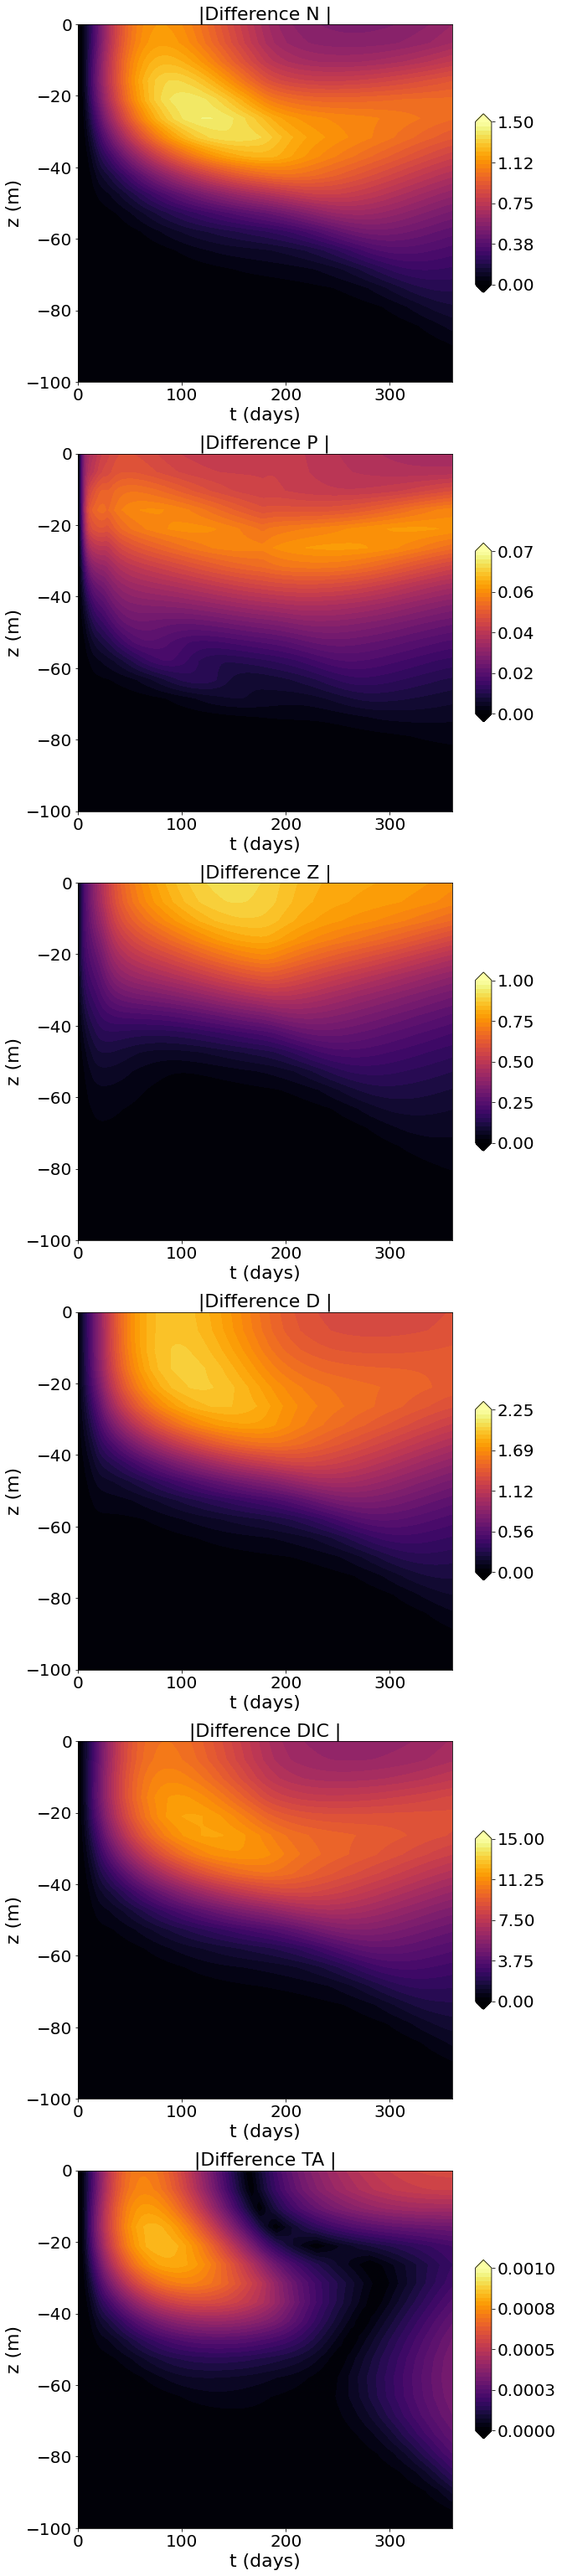

In [38]:
custom_plot_obj.plot(tf.abs(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0) - tf.concat([x_low_complex, val_x_low_complex], axis=0)), '|Difference', '|', max_cbar = [[0, 1.5], [0, 0.075], [0, 1.], [0, 2.25], [0, 15.], [0, .001]], cmap=cm.inferno, str_fmt = '%.4f')

### Compute errors

In [52]:
class compute_error():
    
    def __init__(self, truth, thres = 0.02):
        self.truth = truth
        self.thres = thres
        
    def l2_error(self, pred):
        
        error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.math.squared_difference(pred, self.truth), axis=-1)), axis=0)
        
        return error.numpy()
    
    def RMSE(self, pred):
        
        thres = tf.reduce_max(self.truth)*self.thres
        error = []
        diff = pred - self.truth
        
        for i in range(1, pred.shape[0]):
            diff_t = np.abs(np.squeeze(diff[i, :, :].numpy()))
            error_t = diff_t[np.where(diff_t >= thres)]
            if len(error_t) == 0: continue
            error_t = np.sqrt(np.sum(error_t**2)/len(error_t))
            error.append(error_t)
        
        error = np.mean(np.array(error))
        return error

In [16]:
truth_all = tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0)
pred_y = tf.concat([x_low_complex, val_x_low_complex], axis=0)

In [40]:
truth = truth_all[:, :, 0:args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error N: ', np.round(err_obj.l2_error(pred_y[:, :, 0:args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) N: ', np.round(err_obj.RMSE(pred_y[:, :, 0:args.args_eval_lf.nz]), 3))

L2 error N:  [2.864]
RMSE error (>2%) N:  0.919


In [41]:
truth = truth_all[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error P: ', np.round(err_obj.l2_error(pred_y[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) P: ', np.round(err_obj.RMSE(pred_y[:, :, args.args_eval_lf.nz:2*args.args_eval_lf.nz]), 3))

L2 error P:  [0.135]
RMSE error (>2%) P:  0.036


In [42]:
truth = truth_all[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error Z: ', np.round(err_obj.l2_error(pred_y[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) Z: ', np.round(err_obj.RMSE(pred_y[:, :, 2*args.args_eval_lf.nz:3*args.args_eval_lf.nz]), 3))

L2 error Z:  [1.729]
RMSE error (>2%) Z:  0.496


In [43]:
truth = truth_all[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error D: ', np.round(err_obj.l2_error(pred_y[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) D: ', np.round(err_obj.RMSE(pred_y[:, :, 3*args.args_eval_lf.nz:4*args.args_eval_lf.nz]), 3))

L2 error D:  [4.331]
RMSE error (>2%) D:  1.27


In [44]:
truth = truth_all[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error DIC: ', np.round(err_obj.l2_error(pred_y[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]), 3))

print('RMSE error (>2%) DIC: ', np.round(err_obj.RMSE(pred_y[:, :, 4*args.args_eval_lf.nz:5*args.args_eval_lf.nz]), 3))

L2 error DIC:  [25.412]
RMSE error (>2%) DIC:  7.936


In [53]:
truth = truth_all[:, :, 5*args.args_eval_lf.nz:6*args.args_eval_lf.nz]

err_obj = compute_error(truth)

print('L2 error Z: ', np.round(err_obj.l2_error(pred_y[:, :, 5*args.args_eval_lf.nz:6*args.args_eval_lf.nz]), 5))

print('RMSE error (>2%) Z: ', np.round(err_obj.RMSE(pred_y[:, :, 5*args.args_eval_lf.nz:6*args.args_eval_lf.nz]), 3))

L2 error Z:  [0.00121]
RMSE error (>2%) Z:  nan


### Just plot training data

In [ ]:
custom_plot_obj = custom_plot(args.z, t[0:int(len(t.numpy())*30/182)], args, K_z_obj)

In [ ]:
custom_plot_obj.plot_with_mld(true_x_low_complex[0:int(len(t.numpy())*30/182), ], 'True', '(NNPZD)', max_cbar = [30., 11., 14.], cmap = cm.cubehelix, t_max=364)

In [ ]:
custom_plot_obj.plot_solar_intensity(t_max=364)

In [ ]:
custom_plot_obj = custom_plot(args.z, tf.concat([t, val_t], axis=0), args, K_z_obj)

custom_plot_obj.plot_indiv_cover_img(tf.concat([true_x_low_complex, val_true_x_low_complex], axis=0), 'True', '(NNPZD)', max_cbar = 14., cmap = cm.cubehelix)